In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from icecream import ic

In [2]:
image_path = "./Image"
mask_path = "./Mask"
image_path_list = sorted(os.listdir(image_path))
mask_path_list = sorted(os.listdir(mask_path))
image_path_list = [os.path.join(image_path, i) for i in image_path_list]
mask_path_list = [os.path.join(mask_path, i) for i in mask_path_list]

In [3]:
# load images and masks
def load_images(image_list, mask_list):
    images = []
    masks = []
    for i in range(len(image_list)):
        image = plt.imread(image_list[i])
        mask = plt.imread(mask_list[i])
        images.append(image)
        masks.append(mask)
    return images, masks
images, masks = load_images(image_path_list, mask_path_list)

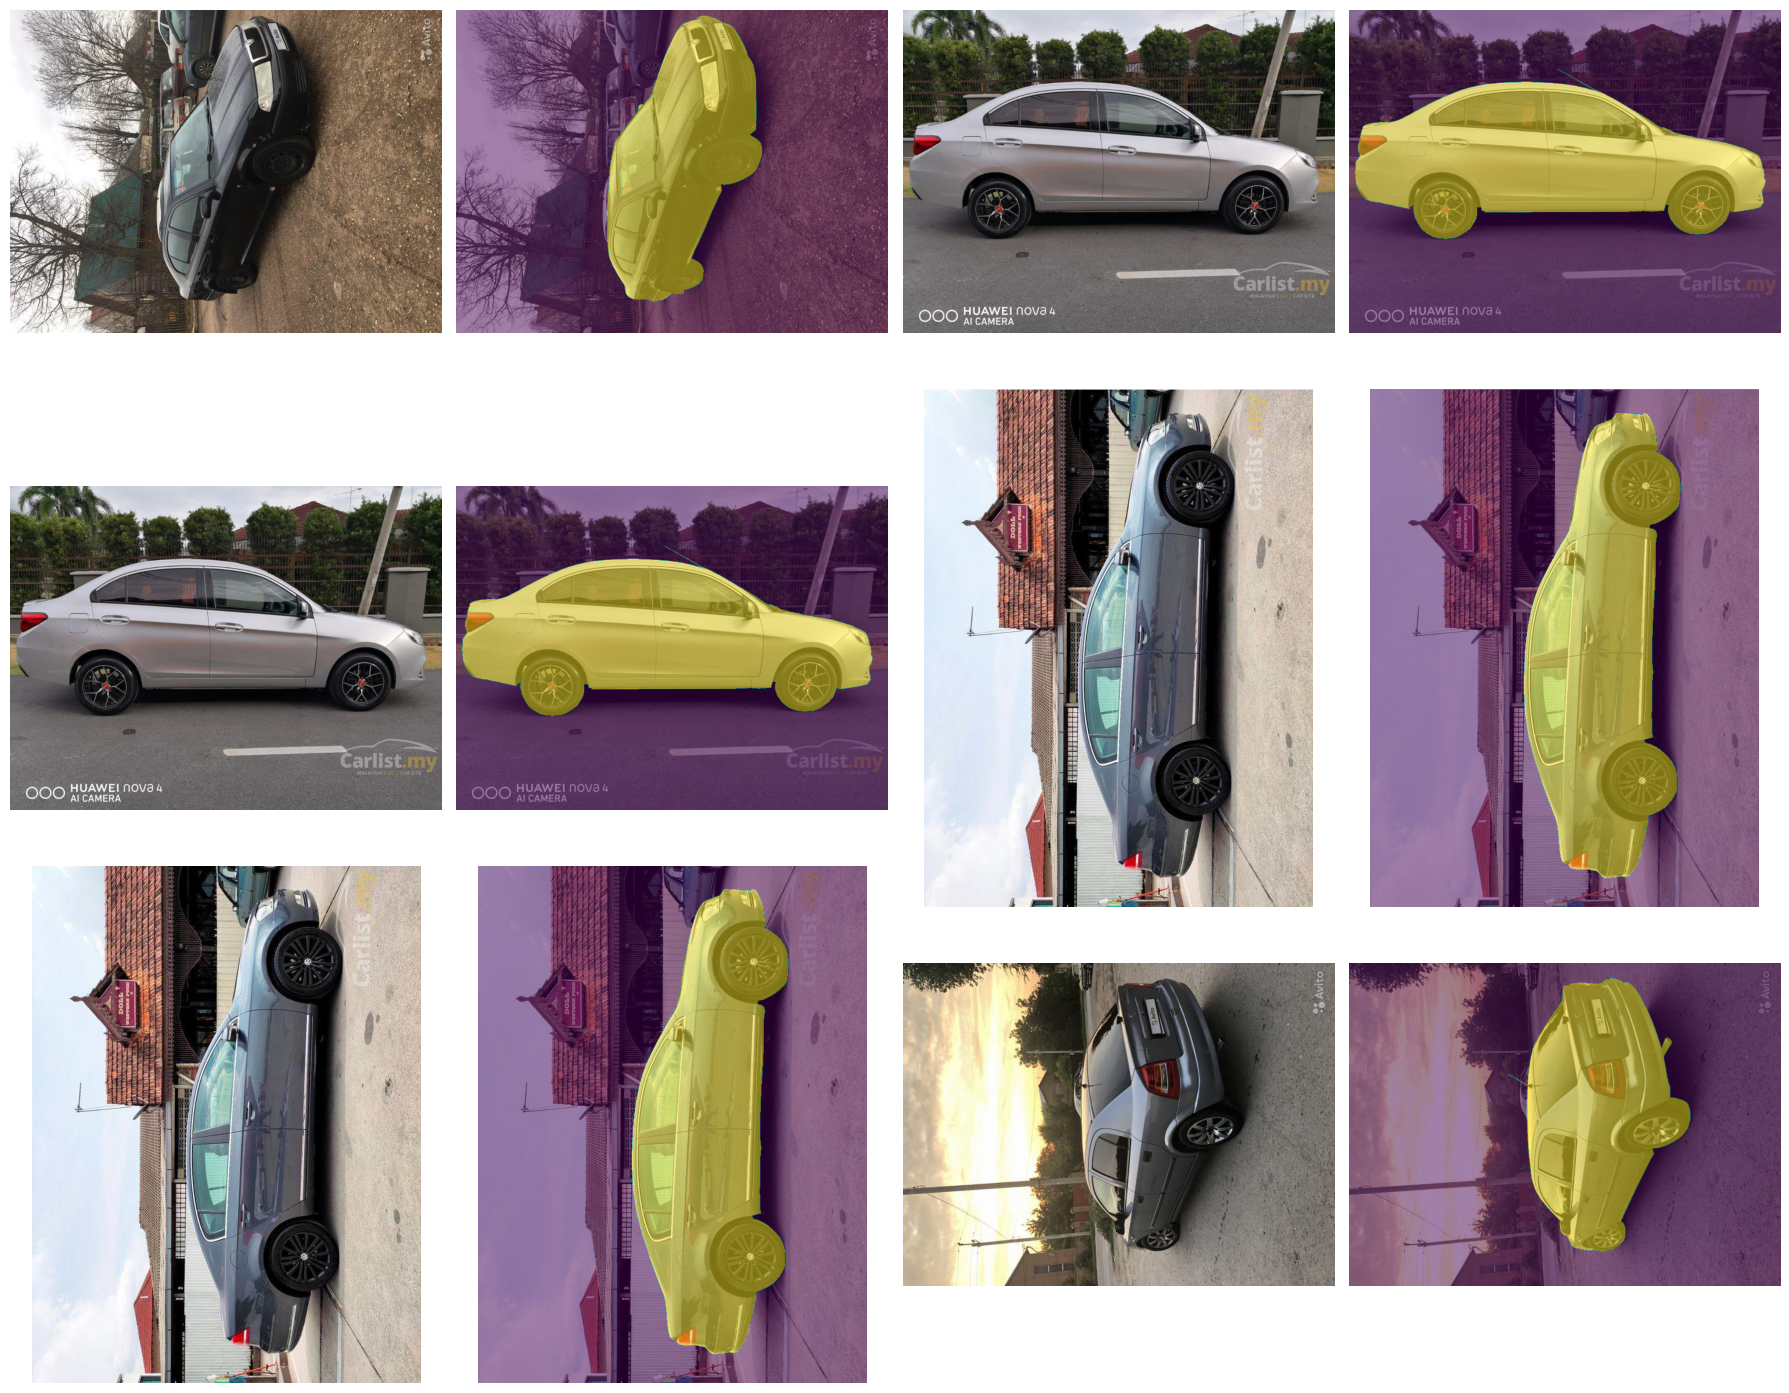

In [4]:
# plot images and masked images
def plot_image_mask(images, masks, nums=3):
    fig, axs = plt.subplots(nums, 4, figsize=(18, 15))  # Increase figure size
    for i in range(nums):
        for j in range(4):
            axs[i, j].axis('off')  # Hide the axes
        axs[i,0].imshow(images[i])
        axs[i,1].imshow(images[i])
        axs[i,1].imshow(masks[i], alpha=0.5)
        axs[i,2].imshow(images[i+1])
        axs[i,3].imshow(images[i+1])
        axs[i,3].imshow(masks[i+1], alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_image_mask(images, masks)

In [5]:
from sklearn.model_selection import train_test_split
train_size = 15
data = list(zip(image_path_list, mask_path_list))
train_images_path, test_images_path = train_test_split(data, train_size=train_size, shuffle=True)

In [6]:
# load image in Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image
img_height, img_width = 320, 320
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width), interpolation=transforms.InterpolationMode.BICUBIC),
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # random flip
    transforms.RandomHorizontalFlip(),
    # random rotation
    transforms.RandomResizedCrop((img_height, img_width)),
    # random rotation
    transforms.RandomRotation((-5,5), interpolation=transforms.InterpolationMode.BILINEAR),
])

class ImageDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.image_path = images_path
        self.transform = transform
    def __len__(self):
        return len(self.image_path)
    def __getitem__(self, idx):
        image_path, mask_path = self.image_path[idx]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

train_dataset = ImageDataset(train_images_path, transform=transform1)
test_dataset = ImageDataset(test_images_path, transform=transform1)


/home/ayush/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


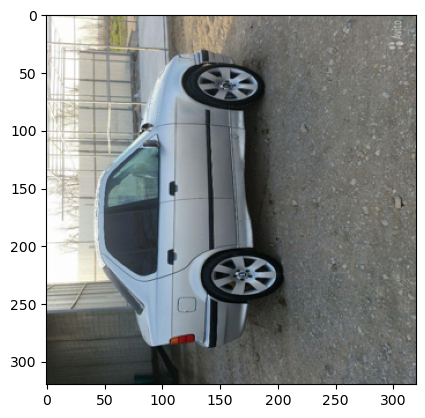

In [7]:
image, mask = train_dataset[0]
plt.imshow(image.permute(1,2,0))

In [8]:
len(train_dataset), len(test_dataset)

(15, 5)

In [9]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 320, 320]), torch.Size([1, 320, 320]))

In [10]:
# apply random crop and flip to the dataset

def random_crop(image, mask, crop_size):
    original_size = image.shape[1:]
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))
    image = transforms.functional.crop(image, i, j, h, w)
    mask = transforms.functional.crop(mask, i, j, h, w)
    image = transforms.functional.resize(image, original_size, interpolation=transforms.InterpolationMode.BILINEAR)
    mask = transforms.functional.resize(mask, original_size, interpolation=transforms.InterpolationMode.NEAREST)
    return image, mask

def random_flip(image, mask):
    if np.random.rand() > 0.5:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask)
    return image, mask

def get_synthetic_data(image, mask, crop_size=256):
    image, mask = random_crop(image, mask, crop_size)
    image, mask = random_flip(image, mask)
    return image, mask

synthetic_data = [get_synthetic_data(image, mask) for image, mask in train_dataset]
# unzipping the synthetic data
synthetic_images, synthetic_masks = zip(*synthetic_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

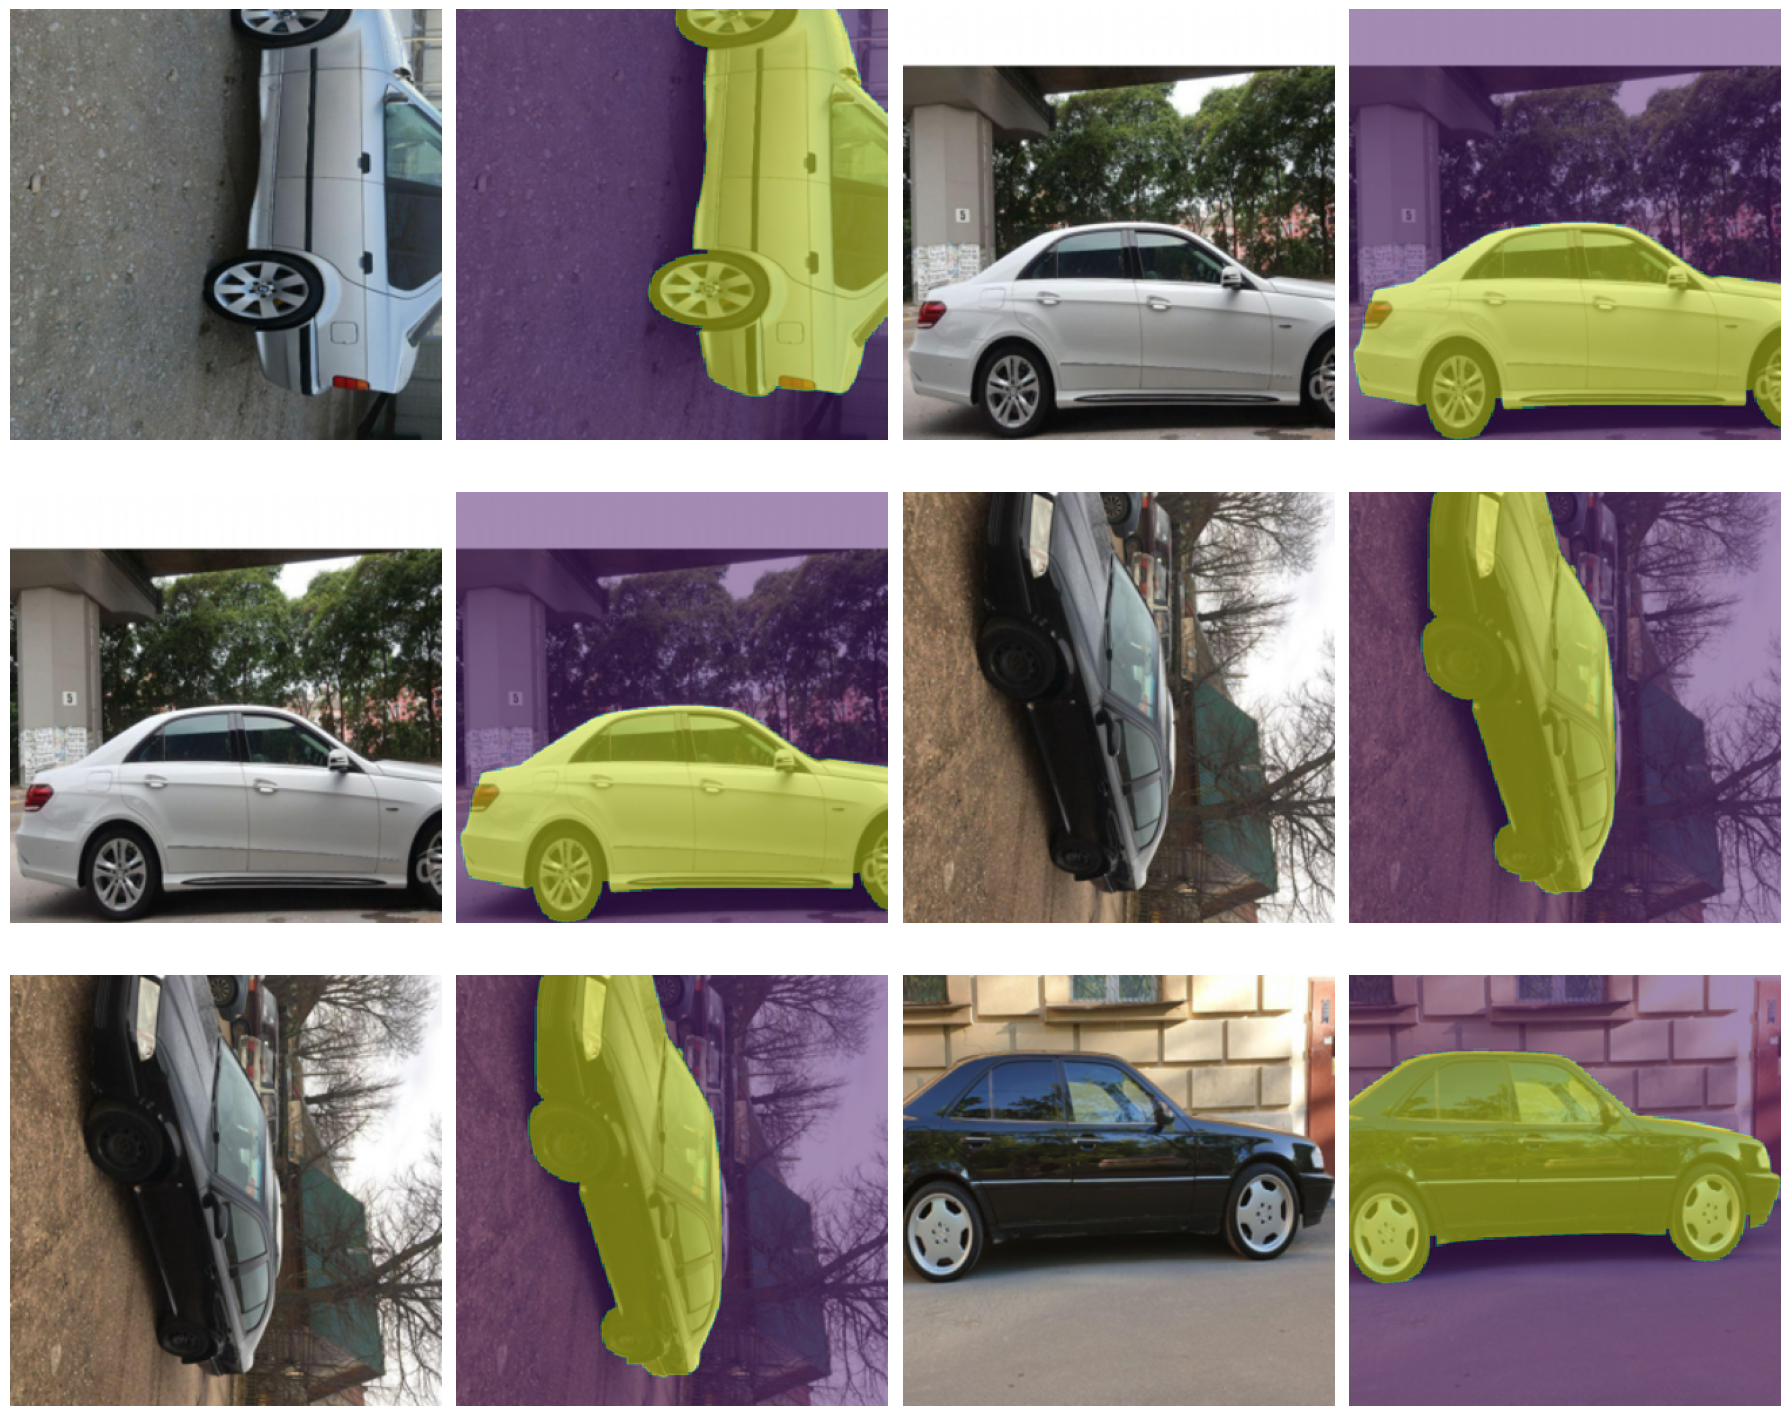

In [11]:
# convert the synthetic data to numpy array
synthetic_images = [np.transpose(np.array(image), (1, 2, 0)) for image in synthetic_images]
synthetic_masks = [np.squeeze(np.array(mask)) for mask in synthetic_masks]

# plot the synthetic data
plot_image_mask(synthetic_images, synthetic_masks)

In [12]:
# split dataset into train and test and create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, prefetch_factor=1, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, prefetch_factor=1, num_workers=1)

In [13]:
# import model
from u2net import U2NET

model = U2NET()
model.to('cuda')

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

In [14]:
import torch
import torch.nn.functional as F

def evaluate(model, data_loader):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    num_batches = 0
    
    with torch.no_grad():
        for image, mask in data_loader:
            image, mask = image.to(device), mask.to(device)
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)
            
            # Calculate metrics
            pixel_acc = (pred_mask == mask).sum().item() / (mask.size(0) * mask.size(1) * mask.size(2))
            intersection = (pred_mask & mask).float().sum((1, 2))
            union = (pred_mask | mask).float().sum((1, 2))
            iou = (intersection / union).mean().item()
            dice = (2 * intersection / (pred_mask.float().sum((1, 2)) + mask.float().sum((1, 2)))).mean().item()
            precision = (intersection / pred_mask.float().sum((1, 2))).mean().item()
            recall = (intersection / mask.float().sum((1, 2))).mean().item()
            
            total_pixel_acc += pixel_acc
            total_iou += iou
            total_dice += dice
            total_precision += precision
            total_recall += recall
            num_batches += 1
    
    avg_pixel_acc = total_pixel_acc / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    
    return avg_pixel_acc, avg_iou, avg_dice, avg_precision, avg_recall

In [15]:
from tqdm import tqdm

In [16]:
def evaluate_batch(pred_mask, mask):
    pixel_acc = (pred_mask == mask).sum().item() / (mask.size(0) * mask.size(1) * mask.size(2))
    intersection = (pred_mask & mask).float().sum((1, 2))
    union = (pred_mask | mask).float().sum((1, 2))
    iou = (intersection / union).mean().item()
    dice = (2 * intersection / (pred_mask.float().sum((1, 2)) + mask.float().sum((1, 2)))).mean().item()
    precision = (intersection / pred_mask.float().sum((1, 2))).mean().item()
    recall = (intersection / mask.float().sum((1, 2))).mean().item()
    
    return pixel_acc, iou, dice, precision, recall

In [25]:
# train function
def train(model, epochs, train_loader, test_loader, criterion, lr=0.001):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_train = [0]*epochs
    loss_test = [0]*epochs
    pixel_acc_train = [0]*epochs
    pixel_acc_test = [0]*epochs
    iou_train = [0]*epochs
    iou_test = [0]*epochs
    dice_train = [0]*epochs
    dice_test = [0]*epochs
    precision_train = [0]*epochs
    precision_test = [0]*epochs
    recall_train = [0]*epochs
    recall_test = [0]*epochs
    for epoch in tqdm(range(epochs)):
        model.train()
        for image, mask in train_loader:
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad()
            pred_mask = model(image)
            if isinstance(pred_mask, tuple):
                pred_mask = pred_mask[0]
            pred_mask = (pred_mask > 0.5).float()
            loss = criterion(pred_mask, mask)
            loss.backward()
            optimizer.step()

            pred_mask = torch.argmax(pred_mask, dim=1)
            pixel_acc, iou, dice, precision, recall = evaluate_batch(pred_mask, mask)

            # Accumulate metrics
            loss_train[epoch] += loss.item()
            pixel_acc_train[epoch] += pixel_acc
            iou_train[epoch] += iou
            dice_train[epoch] += dice
            precision_train[epoch] += precision
            recall_train[epoch] += recall
        
        # Calculate average metrics
        num_batches = len(train_loader)
        loss_train[epoch] /= num_batches
        pixel_acc_train[epoch] /= num_batches
        iou_train[epoch] /= num_batches
        dice_train[epoch] /= num_batches
        precision_train[epoch] /= num_batches
        recall_train[epoch] /= num_batches

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            for image, mask in test_loader:
                image, mask = image.to(device), mask.to(device)
                pred_mask = model(image)
                if isinstance(pred_mask, tuple):
                    pred_mask = pred_mask[0]
                pred_mask = torch.argmax(pred_mask, dim=1)
                loss = criterion(pred_mask, mask)
                loss_test[epoch] += loss.item()
                pixel_acc, iou, dice, precision, recall = evaluate_batch(pred_mask, mask)
                pixel_acc_test[epoch] += pixel_acc
                iou_test[epoch] += iou
                dice_test[epoch] += dice
                precision_test[epoch] += precision
                recall_test[epoch] += recall
        
        num_batches_test = len(test_loader)
        loss_test[epoch] /= num_batches_test
        pixel_acc_test[epoch] /= num_batches_test
        iou_test[epoch] /= num_batches_test
        dice_test[epoch] /= num_batches_test
        precision_test[epoch] /= num_batches_test
        recall_test[epoch] /= num_batches_test

    return loss_train, loss_test, pixel_acc_train, pixel_acc_test, iou_train, iou_test, dice_train, dice_test, precision_train, precision_test, recall_train, recall_test

In [26]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()
        
        intersection = (preds * targets).sum(dim=2).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) + self.smooth)
        
        return 1 - dice.mean()

In [55]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_batch(pred_mask, mask):
    pixel_acc = (pred_mask == mask).sum().item() / (mask.size(0) * mask.size(1) * mask.size(2))
    intersection = (pred_mask * mask).sum((1, 2))
    union = (pred_mask + mask).sum((1, 2)) - intersection
    iou = (intersection / union).mean().item()
    dice = (2 * intersection / (pred_mask.sum((1, 2)) + mask.sum((1, 2)))).mean().item()
    precision = (intersection / pred_mask.sum((1, 2))).mean().item()
    recall = (intersection / mask.sum((1, 2))).mean().item()
    
    return pixel_acc, iou, dice, precision, recall

def train(model, epochs, train_loader, test_loader, criterion, lr=0.001):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_train = [0]*epochs
    loss_test = [0]*epochs
    pixel_acc_train = [0]*epochs
    pixel_acc_test = [0]*epochs
    iou_train = [0]*epochs
    iou_test = [0]*epochs
    dice_train = [0]*epochs
    dice_test = [0]*epochs
    precision_train = [0]*epochs
    precision_test = [0]*epochs
    recall_train = [0]*epochs
    recall_test = [0]*epochs
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for image, mask in train_loader:
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad()
            pred_mask = model(image)
            if isinstance(pred_mask, tuple):
                pred_mask = pred_mask[0]
            # ic(pred_mask.shape, mask.shape)
            loss = criterion(pred_mask, mask)
            loss.backward()
            optimizer.step()

            pred_mask = 1 * (pred_mask > 0.5)
            pixel_acc, iou, dice, precision, recall = evaluate_batch(pred_mask, mask)

            # Accumulate metrics
            loss_train[epoch] += loss.item()
            pixel_acc_train[epoch] += pixel_acc
            iou_train[epoch] += iou
            dice_train[epoch] += dice
            precision_train[epoch] += precision
            recall_train[epoch] += recall
        
        # Calculate average metrics
        num_batches = len(train_loader)
        loss_train[epoch] /= num_batches
        pixel_acc_train[epoch] /= num_batches
        iou_train[epoch] /= num_batches
        dice_train[epoch] /= num_batches
        precision_train[epoch] /= num_batches
        recall_train[epoch] /= num_batches

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            for image, mask in test_loader:
                image, mask = image.to(device), mask.to(device)
                pred_mask = model(image)
                if isinstance(pred_mask, tuple):
                    pred_mask = pred_mask[0]
                pred_mask = 1 * (pred_mask > 0.5)
                loss = criterion(pred_mask, mask)
                loss_test[epoch] += loss.item()
                pixel_acc, iou, dice, precision, recall = evaluate_batch(pred_mask, mask)
                pixel_acc_test[epoch] += pixel_acc
                iou_test[epoch] += iou
                dice_test[epoch] += dice
                precision_test[epoch] += precision
                recall_test[epoch] += recall
        
        num_batches_test = len(test_loader)
        loss_test[epoch] /= num_batches_test
        pixel_acc_test[epoch] /= num_batches_test
        iou_test[epoch] /= num_batches_test
        dice_test[epoch] /= num_batches_test
        precision_test[epoch] /= num_batches_test
        recall_test[epoch] /= num_batches_test
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss_train[epoch]:.4f}, Pixel Acc: {pixel_acc_train[epoch]:.4f}, IoU: {iou_train[epoch]:.4f}, Dice: {dice_train[epoch]:.4f}, Precision: {precision_train[epoch]:.4f}, Recall: {recall_train[epoch]:.4f}")
    return loss_train, loss_test, pixel_acc_train, pixel_acc_test, iou_train, iou_test, dice_train, dice_test, precision_train, precision_test, recall_train, recall_test

In [53]:
criteria = DiceLoss()
history = train(model, 10, train_loader, test_loader, criteria, lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([1, 1, 320, 320])
    mask.shape: torch.Size([1, 1, 320, 320])
 10%|█         | 1/10 [00:14<02:10, 14.47s/it]ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.shape: torch.Size([2, 1, 320, 320])
ic| pred_mask.shape: torch.Size([2, 1, 320, 320])
    mask.sh

In [54]:
# plot the training and testing loss and metrics
def plot_metrics(history):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs[0, 0].plot(history[0], label="train")
    axs[0, 0].plot(history[1], label="test")
    axs[0, 0].set_title("Loss")
    axs[0, 0].legend()
    axs[0, 1].plot(history[2], label="train")
    axs[0, 1].plot(history[3], label="test")
    axs[0, 1].set_title("Pixel Accuracy")
    axs[0, 1].legend()
    axs[0, 2].plot(history[4], label="train")
    axs[0, 2].plot(history[5], label="test")
    axs[0, 2].set_title("IoU")
    axs[0, 2].legend()
    axs[1, 0].plot(history[6], label="train")
    axs[1, 0].plot(history[7], label="test")
    axs[1, 0].set_title("Dice")
    axs[1, 0].legend()
    axs[1, 1].plot(history[8], label="train")
    axs[1, 1].plot(history[9], label="test")
    axs[1, 1].set_title("Precision")
    axs[1, 1].legend()
    axs[1, 2].plot(history[10], label="train")
    axs[1, 2].plot(history[11], label="test")
    axs[1, 2].set_title("Recall")
    axs[1, 2].legend()
    plt.show()

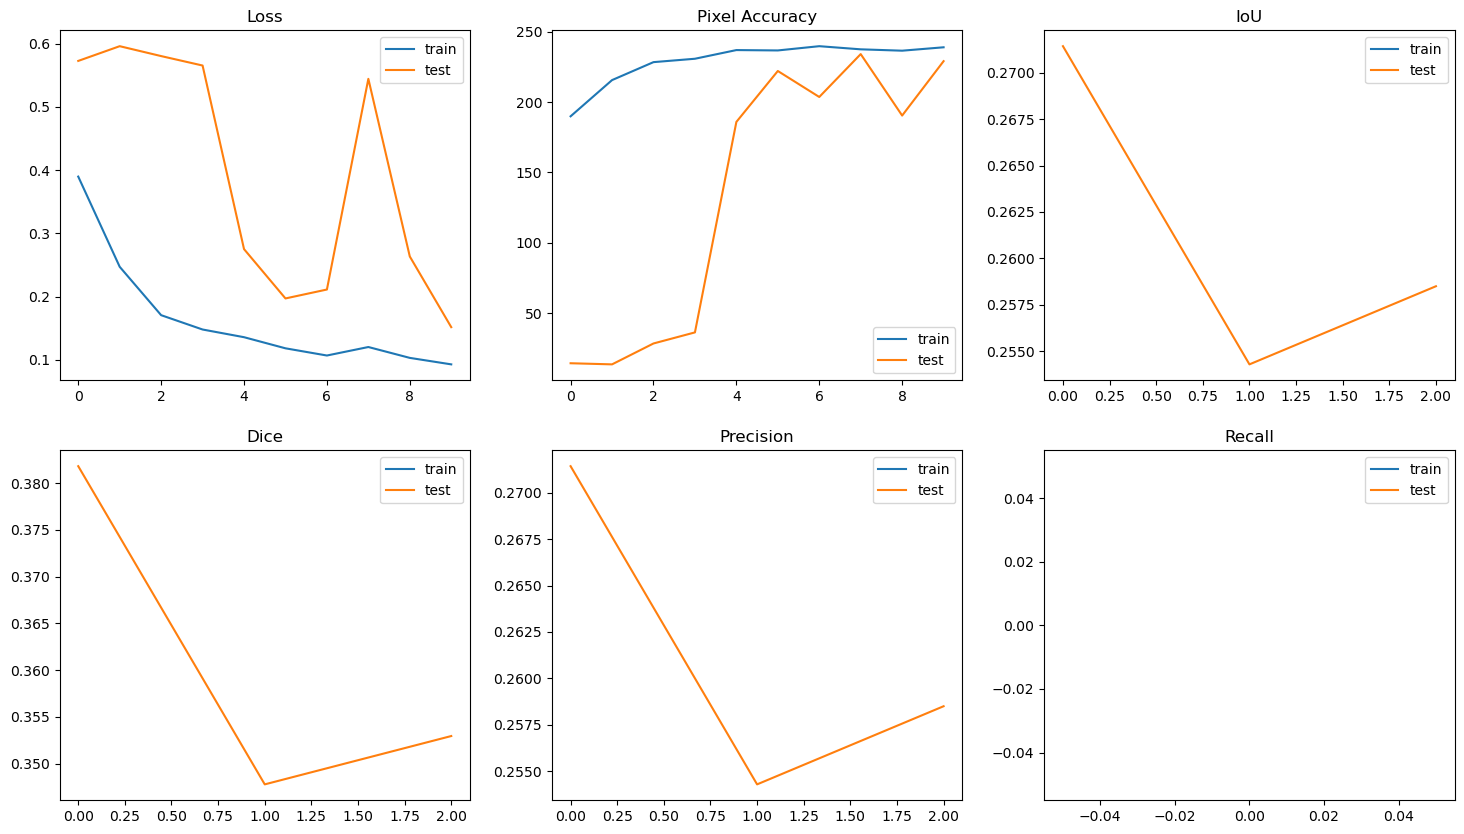

In [56]:
plot_metrics(history)